# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In Chapter 10 we introduced artificial neural networks and trained our first deep
neural networks. But they were shallow nets, with just a few hidden layers. What if
you need to tackle a complex problem, such as detecting hundreds of types of objects
in high-resolution images? You may need to train a much deeper DNN, perhaps with
10 layers or many more, each containing hundreds of neurons, linked by hundreds of
thousands of connections. Training a deep DNN isn’t a walk in the park. Here are
some of the problems you could run into:

- You may be faced with the tricky vanishing gradients problem or the related
    exploding gradients problem. This is when the gradients grow smaller and
    smaller, or larger and larger, when flowing backward through the DNN during
    training. Both of these problems make lower layers very hard to train.
- You might not have enough training data for such a large network, or it might be
    too costly to label.
- Training may be extremely slow.
- A model with millions of parameters would severely risk overfitting the training
    set, especially if there are not enough training instances or if they are too noisy.

# The Vanishing/Exploding Gradients Problems

Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces in recurrent neural networks (see Chapter 15). More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

In [1]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


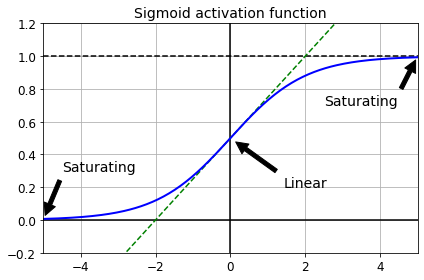

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

##  Xavier and He Initialization / Glorot Initalization

Using Glorot initialization can speed up training considerably, and it is
one of the tricks that led to the success of Deep Learning.

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

![](images/init.png)

By default, Keras uses Glorot initialization with a uniform distribution. When creating
a layer, you can change this to He initialization by setting kernel_initial

In [8]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")


If you want He initialization with a uniform distribution but based on fanavg rather than fanin, you can use the VarianceScaling initializer like this:

In [9]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

##  Nonsaturating Activation Functions

Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0.** In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

**To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU**

### Leaky ReLU

The hyperparameter α defines how much the function “leaks”: it is the
slope of the function for z < 0 and is typically set to 0.01.

A 2015 paper compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting α = 0.2 (a huge leak) seemed to result in better performance than α = 0.01 (a small leak).

The paper also evaluated the randomized leaky ReLU (RReLU), where α is picked randomly in a given range during training and is fixed to an average value during testing. RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set).

Finally, the paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other param‐ eter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


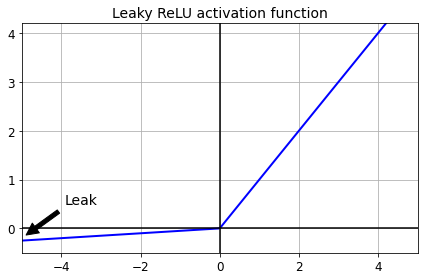

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [12]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [13]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy

Now let's try PReLU:

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [20]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7886
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accu

### Exponential Linear Unit (ELU)

Last but not least, a 2015 paper by Djork-Arné Clevert et al.6 proposed a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.

The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


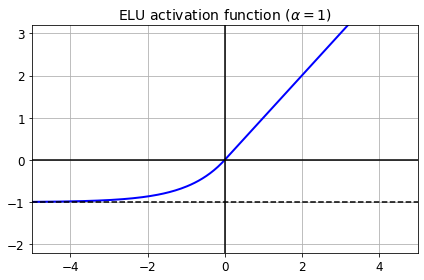

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
keras.layers.Dense(10, activation="elu")

### Selu

Then, a 2017 paper7 by Günter Klambauer et al. introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):
- The input features must be standardized (mean 0 and standard deviation 1).
- Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal".
- The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
- The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well (see Chapter 14).


This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [24]:

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [25]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


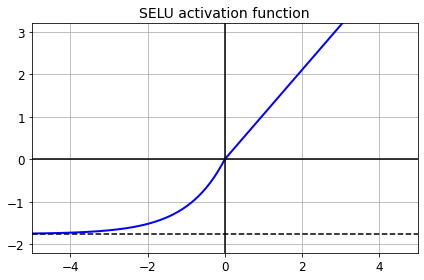

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:

np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [29]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [8]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 65s 38ms/step - loss: 1.0076 - accuracy: 0.6162 - val_loss: 0.8929 - val_accuracy: 0.6836
Epoch 2/5
1719/1719 [==============================] - 66s 38ms/step - loss: 0.6358 - accuracy: 0.7773 - val_loss: 0.5437 - val_accuracy: 0.8146
Epoch 3/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.5336 - accuracy: 0.8146 - val_loss: 0.5033 - val_accuracy: 0.8214
Epoch 4/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.4889 - accuracy: 0.8297 - val_loss: 0.4757 - val_accuracy: 0.8342
Epoch 5/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.4487 - accuracy: 0.8438 - val_loss: 0.4298 - val_accuracy: 0.8504


Now look at what happens if we try to use the ReLU activation function instead:

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 55s 32ms/step - loss: 1.7881 - accuracy: 0.2715 - val_loss: 1.8198 - val_accuracy: 0.2938
Epoch 2/5
1719/1719 [==============================] - 55s 32ms/step - loss: 1.1090 - accuracy: 0.5347 - val_loss: 0.9632 - val_accuracy: 0.5974
Epoch 3/5
1719/1719 [==============================] - 51s 29ms/step - loss: 1.0872 - accuracy: 0.5563 - val_loss: 1.0153 - val_accuracy: 0.5952
Epoch 4/5
1719/1719 [==============================] - 53s 31ms/step - loss: 1.0576 - accuracy: 0.5843 - val_loss: 1.0003 - val_accuracy: 0.6168
Epoch 5/5
1719/1719 [==============================] - 52s 30ms/step - loss: 0.9623 - accuracy: 0.6375 - val_loss: 0.8725 - val_accuracy: 0.6774


**TIP:** So, which activation function should you use for the hidden layers
of your deep neural networks? Although your mileage will vary, in
general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If the network’s architecture prevents it from selfnormalizing,
then ELU may perform better than SELU (since SELU
is not smooth at z = 0). If you care a lot about runtime latency, then
you may prefer leaky ReLU. If you don’t want to tweak yet another
hyperparameter, you may use the default α values used by Keras
(e.g., 0.3 for leaky ReLU). If you have spare time and computing
power, you can use cross-validation to evaluate other activation
functions, such as RReLU if your network is overfitting or PReLU
if you have a huge training set. That said, because ReLU is the most
used activation function (by far), many libraries and hardware
accelerators provide ReLU-specific optimizations; therefore, if
speed is your priority, ReLU might still be the best choice.

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly
reduce the danger of the vanishing/exploding gradients problems at the beginning
of training, it doesn’t guarantee that they won’t come back during training.

The technique consists of
adding an operation in the model just before or after the activation function of each
hidden layer. This operation simply zero-centers and normalizes each input, then
scales and shifts the result using two new parameter vectors per layer: one for scaling,
the other for shifting. In other words, the operation lets the model learn the optimal
scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as
the very first layer of your neural network, you do not need to standardize your training
set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately,
since it only looks at one batch at a time, and it can also rescale and shift each
input feature).

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all
the deep neural networks they experimented with, leading to a huge improvement in
the ImageNet classification task (ImageNet is a large database of images classified into
many classes, commonly used to evaluate computer vision systems). The vanishing
gradients problem was strongly reduced, to the point that they could use saturating
activation functions such as the tanh and even the logistic activation function. The
networks were also much less sensitive to the weight initialization. The authors were
able to use much larger learning rates, significantly speeding up the learning process.

Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer,
reducing the need for other regularization techniques (such as dropout, described
later in this chapter).

Batch Normalization does, however, add some complexity to the model (although it
can remove the need for normalizing the input data, as we discussed earlier). Moreover,
there is a runtime penalty: the neural network makes slower predictions due to
the extra computations required at each layer. Fortunately, it’s often possible to fuse
the BN layer with the previous layer, after training, thereby avoiding the runtime penalty.
This is done by updating the previous layer’s weights and biases so that it directly
produces outputs of the appropriate scale and offset.

**NOTE:** You may find that training is rather slow, because each epoch takes
much more time when you use Batch Normalization. This is usually
counterbalanced by the fact that convergence is much faster
with BN, so it will take fewer epochs to reach the same performance.
All in all, wall time will usually be shorter (this is the time
measured by the clock on your wall).

### Implementing Batch Normalization with Keras

As with most things with Keras, implementing Batch Normalization is simple and
intuitive. Just add a BatchNormalization layer before or after each hidden layer’s
activation function, and optionally add a BN layer as well as the first layer in your
model. For example, this model applies BN after every hidden layer and as the first
layer in the model (after flattening the input images):

In [2]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

That’s all! In this tiny example with just two hidden layers, it’s unlikely that Batch
Normalization will have a very positive impact; but for deeper networks it can make a
tremendous difference.

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

As you can see, each BN layer adds four parameters per input: γ, β, μ, and σ (for
example, the first BN layer adds 3,136 parameters, which is 4 × 784). The last two
parameters, μ and σ, are the moving averages; they are not affected by backpropagation,
so Keras calls them “non-trainable”9 (if you count the total number of BN
parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total
number of non-trainable parameters in this model).

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation),
and two are not:

In [10]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8373 - accuracy: 0.7209 - val_loss: 0.5422 - val_accuracy: 0.8186
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5619 - accuracy: 0.8065 - val_loss: 0.4664 - val_accuracy: 0.8430
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5047 - accuracy: 0.8245 - val_loss: 0.4334 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4718 - accuracy: 0.8345 - val_loss: 0.4126 - val_accuracy: 0.8596
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4497 - accuracy: 0.8421 - val_loss: 0.3986 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4339 - accuracy: 0.8481 - val_loss: 0.3874 - val_accuracy: 0.8658
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4147 - accuracy: 0.8531 - val_loss: 0.3794 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

The authors of the BN paper argued in favor of adding the BN layers before the activation
functions, rather than after (as we just did). There is some debate about this, as
which is preferable seems to depend on the task—you can experiment with this too to
see which option works best on your dataset. To add the BN layers before the activation
functions, you must remove the activation function from the hidden layers and
add them as separate layers after the BN layers. Moreover, since a Batch Normalization
layer includes one offset parameter per input, you can remove the bias term from
the previous layer (just pass use_bias=False when creating it):

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0497 - accuracy: 0.6745 - val_loss: 0.6623 - val_accuracy: 0.7886
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6709 - accuracy: 0.7834 - val_loss: 0.5470 - val_accuracy: 0.8190
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5846 - accuracy: 0.8059 - val_loss: 0.4930 - val_accuracy: 0.8350
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5382 - accuracy: 0.8196 - val_loss: 0.4604 - val_accuracy: 0.8452
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5056 - accuracy: 0.8288 - val_loss: 0.4375 - val_accuracy: 0.8524
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4844 - accuracy: 0.8358 - val_loss: 0.4236 - val_accuracy: 0.8536
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4688 - accuracy: 0.8392 - val_loss: 0.4095 - val_accuracy:

The BatchNormalization class has quite a few hyperparameters you can tweak. The
defaults will usually be fine, but you may occasionally need to tweak the momentum.
A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you
want more 9s for larger datasets and smaller mini-batches).

Another important hyperparameter is axis: it determines which axis should be normalized.
It defaults to –1, meaning that by default it will normalize the last axis (using
the means and standard deviations computed across the other axes). When the input
batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input
feature will be normalized based on the mean and standard deviation computed
across all the instances in the batch.

BatchNormalization has become one of the most-used layers in deep neural networks,
to the point that it is often omitted in the diagrams, as it is assumed that BN is
added after every layer.

But a recent paper by Hongyi Zhang et al. may change this
assumption: by using a novel fixed-update (fixup) weight initialization technique, the
authors managed to train a very deep neural network (10,000 layers!) without BN,
achieving state-of-the-art performance on complex image classification tasks. As this
is bleeding-edge research, however, you may want to wait for additional research to
confirm this finding before you drop Batch Normalization

## Gradient Clipping 

Another popular technique to mitigate the exploding gradients problem is to clip the
gradients during backpropagation so that they never exceed some threshold. This is
called Gradient Clipping. This technique is most often used in recurrent neural networks,
as Batch Normalization is tricky to use in RNNs, as we will see in Chapter 15.
For other types of networks, BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or
clipnorm argument when creating an optimizer, like this:

In [14]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [15]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

This optimizer will clip every component of the gradient vector to a value between
–1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each
and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is
a hyperparameter you can tune.

Note that it may change the orientation of the gradient
vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly
in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0],
which points roughly in the diagonal between the two axes. In practice, this approach
works well. 

If you want to ensure that Gradient Clipping does not change the direction
of the gradient vector, you should clip by norm by setting clipnorm instead of
clipvalue. This will clip the whole gradient if its ℓ2 norm is greater than the threshold
you picked. For example, if you set clipnorm=1.0, then the vector [0.9, 100.0]
will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating
the first component. If you observe that the gradients explode during training
(you can track the size of the gradients using TensorBoard), you may want to try both
clipping by value and clipping by norm, with different thresholds, and see which
option performs best on the validation set.

# Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you
should always try to find an existing neural network that accomplishes a similar task
to the one you are trying to tackle (we will discuss how to find them in Chapter 14),
then reuse the lower layers of this network. This technique is called **transfer learning**.

It will not only speed up training considerably, but also require significantly less
training data.

![](images/reuse_1.png)

**NOTE**: If the input pictures of your new task don’t have the same size as
the ones used in the original task, you will usually have to add a
preprocessing step to resize them to the size expected by the original
model. More generally, transfer learning will work best when
the inputs have similar low-level features.

The output layer of the original model should usually be replaced because it is most
likely not useful at all for the new task, and it may not even have the right number of
outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful
as the lower layers, since the high-level features that are most useful for the new task
may differ significantly from the ones that were most useful for the original task. You
want to find the right number of layers to reuse.

**TIP**: The more similar the tasks are, the more layers you want to reuse
(starting with the lower layers). For very similar tasks, try keeping
all the hidden layers and just replacing the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that
Gradient Descent won’t modify them), then train your model and see how it performs.
Then try unfreezing one or two of the top hidden layers to let backpropagation
tweak them and see if performance improves. The more training data you have,
the more layers you can unfreeze. It is also useful to reduce the learning rate when
you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping
the top hidden layer(s) and freezing all the remaining hidden layers again. You
can iterate until you find the right number of layers to reuse. If you have plenty of
training data, you may try replacing the top hidden layers instead of dropping them,
and even adding more hidden layers.

### Transfer Learning with Keras

Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [16]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [17]:
X_train_A.shape

(43986, 28, 28)

In [18]:
X_train_B.shape

(200, 28, 28)

In [19]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [20]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

In [22]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [23]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [24]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3012 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2972 - accuracy: 0.8974 - val_loss: 0.2892 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2834 - accuracy: 0.9020 - val_loss: 0.2775 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2729 - accuracy: 0.9063 - val_loss: 0.2734 - val_accuracy: 0.9068
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2640 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [25]:
model_A.save("my_model_A.h5")

In [26]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [27]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [29]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.1152 - accuracy: 0.9900 - val_loss: 0.1380 - val_accuracy: 0.9716
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1101 - accuracy: 0.9900 - val_loss: 0.1338 - val_accuracy: 0.9736
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.1056 - accuracy: 0.9900 - val_loss: 0.1295 - val_accuracy: 0.9757
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 1.00 - 0s 9ms/step - loss: 0.1016 - accuracy: 0.9900 - val_loss: 0.1259 - val_accuracy: 0.9757
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0977 - accuracy: 0.9900 - val_loss: 0.1225 - val_accuracy: 0.9757
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.0940 - accuracy: 0.9900 - val_loss: 0.1195 - val_accuracy: 0.9757
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9900 - val_loss: 0.1173 - val_accuracy

In [30]:
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [36]:
model_A = keras.models.load_model("my_model_A.h5")
# Takes out last layer (output layer)
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# Add new output layer
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that model_A and model_B_on_A now share some layers. When you train
model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone
model_A before you reuse its layers. To do this, you clone model A’s architecture with
clone_model(), then copy its weights (since clone_model() does not clone the
weights):

In [32]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now you could train model_B_on_A for task B, but since the new output layer was initialized
randomly it will make large errors (at least during the first few epochs), so
there will be large error gradients that may wreck the reused weights. To avoid this,
one approach is to freeze the reused layers during the first few epochs, giving the new
layer some time to learn reasonable weights. To do this, set every layer’s trainable
attribute to False and compile the model

**NOTE**: You must always compile your model after you freeze or unfreeze
layers.

In [42]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

Now you can train the model for a few epochs, then unfreeze the reused layers (which
requires compiling the model again) and continue training to fine-tune the reused
layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce
the learning rate, once again to avoid damaging the reused weights:

In [43]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 24ms/step - loss: 1.3082 - accuracy: 0.3750 - val_loss: 1.2271 - val_accuracy: 0.4391
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 1.1867 - accuracy: 0.4300 - val_loss: 1.1255 - val_accuracy: 0.4878
Epoch 3/4
7/7 [==============================] - 0s 10ms/step - loss: 1.0821 - accuracy: 0.5050 - val_loss: 1.0306 - val_accuracy: 0.5162
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.9849 - accuracy: 0.5600 - val_loss: 0.9415 - val_accuracy: 0.5578
Epoch 1/16
7/7 [==============================] - 0s 23ms/step - loss: 0.6899 - accuracy: 0.6700 - val_loss: 0.4638 - val_accuracy: 0.8114
Epoch 2/16
7/7 [==============================] - 0s 9ms/step - loss: 0.3777 - accuracy: 0.8850 - val_loss: 0.3428 - val_accuracy: 0.9077
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.2807 - accuracy: 0.9600 - val_loss: 0.2748 - val_accuracy: 0.9351
Epoch 4/16
7/7 [===================

So, what's the final verdict?

In [44]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 990us/step - loss: 0.0854 - accuracy: 0.9785


[0.08543381839990616, 0.9785000085830688]

In [45]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0839 - accuracy: 0.9915


[0.08385751396417618, 0.9915000200271606]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 2.5!

In [47]:
(100 - 97.85) / (100 - 99.15)

2.529411764705906

Are you convinced? You shouldn’t be: I cheated! I tried many configurations until I
found one that demonstrated a strong improvement. If you try to change the classes
or the random seed, you will see that the improvement generally drops, or even vanishes
or reverses. What I did is called “torturing the data until it confesses.”

Why did I cheat? It turns out that transfer learning does not work very well with
small dense networks, presumably because small networks learn few patterns, and
dense networks learn very specific patterns, which are unlikely to be useful in other
tasks. Transfer learning works best with deep convolutional neural networks, which
tend to learn feature detectors that are much more general (especially in the lower
layers). We will revisit transfer learning in Chapter 14, using the techniques we just
discussed (and this time there will be no cheating, I promise!).

### Unsupervised Pretraining

If you can gather plenty of unlabeled training data, you can try to use it to train
an unsupervised model, such as an autoencoder or a generative adversarial network
(see Chapter 17). Then you can reuse the lower layers of the autoencoder or the lower
layers of the GAN’s discriminator, add the output layer for your task on top, and finetune
the final network using supervised learning (i.e., with the labeled training
examples).

Unsupervised pretraining (today typically using autoencoders or
GANs rather than RBMs) is still a good option when you have a complex task to
solve, no similar model you can reuse, and little labeled training data but plenty of
unlabeled training data.

![](images/reuse_2.png)

### Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a first neural
network on an auxiliary task for which you can easily obtain or generate labeled
training data, then reuse the lower layers of that network for your actual task. The
first neural network’s lower layers will learn feature detectors that will likely be reusable
by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a
few pictures of each individual—clearly not enough to train a good classifier. Gathering
hundreds of pictures of each person would not be practical. You could, however,
gather a lot of pictures of random people on the web and train a first neural network
to detect whether or not two different pictures feature the same person. Such a
network would learn good feature detectors for faces, so reusing its lower layers
would allow you to train a good face classifier that uses little training data.

**TIP**: Self-supervised learning is when you automatically generate the
labels from the data itself, then you train a model on the resulting
“labeled” dataset using supervised learning techniques. Since this
approach requires no human labeling whatsoever, it is best classified
as a form of unsupervised learning.

# Faster Optimizers

## Momentum Optimisation

**TIP**: Due to the momentum, the optimizer may overshoot a bit, then
come back, overshoot again, and oscillate like this many times
before stabilizing at the minimum. This is one of the reasons it’s
good to have a bit of friction in the system: it gets rid of these oscillations
and thus speeds up convergence.

The one drawback of momentum optimization is that it adds yet another hyperparameter
to tune. However, the momentum value of 0.9 usually works well in practice
and almost always goes faster than regular Gradient Descent.

In [3]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

NAG is generally faster than regular momentum optimization

In [4]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

![](images/momentum_1.png)

## AdaGrad

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions
than for dimensions with gentler slopes. This is called an adaptive learning rate.
It helps point the resulting updates more directly toward the global optimum (see
Figure 11-7). One additional benefit is that it requires much less tuning of the learning
rate hyperparameter η.

AdaGrad frequently performs well for simple quadratic problems, but it often stops
too early when training neural networks. The learning rate gets scaled down so much
that the algorithm ends up stopping entirely before reaching the global optimum. **So
even though Keras has an Adagrad optimizer, you should not use it to train deep neural
networks (it may be efficient for simpler tasks such as Linear Regression, though).**
Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate
optimizers.

![](images/ada_grad.png)

In [5]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but
this default value often works well, so you may not need to tune it at all.

Note that the rho argument corresponds to β in Equation 11-7. Except on very simple
problems, this optimizer almost always performs much better than AdaGrad. In fact,
it was the preferred optimization algorithm of many researchers until Adam optimization
came around.

In [6]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

Adam, which stands for adaptive moment estimation, combines the ideas of momentum
optimization and RMSProp: just like momentum optimization, it keeps track of
an exponentially decaying average of past gradients; and just like RMSProp, it keeps
track of an exponentially decaying average of past squared gradients (see Equation
11-8).

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it
requires less tuning of the learning rate hyperparameter η. You can often use the
default value η = 0.001, making Adam even easier to use than Gradient Descent.

In [7]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [8]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [9]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

**WARNING**: Adaptive optimization methods (including RMSProp, Adam, and
Nadam optimization) are often great, converging fast to a good solution.
However, a 2017 paper20 by Ashia C. Wilson et al. showed
that they can lead to solutions that generalize poorly on some datasets.
So when you are disappointed by your model’s performance,
try using plain Nesterov Accelerated Gradient instead: your dataset
may just be allergic to adaptive gradients. Also check out the latest
research, because it’s moving fast.

All the optimization techniques discussed so far only rely on the first-order partial
derivatives (Jacobians). The optimization literature also contains amazing algorithms
based on the second-order partial derivatives (the Hessians, which are the partial
derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply
to deep neural networks because there are n2 Hessians per output (where n is the
number of parameters), as opposed to just n Jacobians per output. Since DNNs typically
have tens of thousands of parameters, the second-order optimization algorithms
often don’t even fit in memory, and even when they do, computing the Hessians is
just too slow.

![](images/sparse_models.png)

![](images/compare_opt.png)

## Learning Rate Scheduling

![](images/learning_curves.png)

**You can find a good learning rate by training the
model for a few hundred iterations, exponentially increasing the learning rate from a
very small value to a very large value, and then looking at the learning curve and
picking a learning rate slightly lower than the one at which the learning curve starts
shooting back up. You can then reinitialize your model and train it with that learning
rate.**

**But you can do better than a constant learning rate: if you start with a large learning
rate and then reduce it once training stops making fast progress, you can reach a
good solution faster than with the optimal constant learning rate.** There are many different
strategies to reduce the learning rate during training. It can also be beneficial to
start with a low learning rate, increase it, then drop it again. These strategies are
called learning schedules

### Power Scheduling
lr = lr0 / (1 + steps / s)**c

- Keras uses c=1 and s = 1 / decay

Set the learning rate to a function of the iteration number t: η(t) = η0 / (1 + t/s)c.
The initial learning rate η0, the power c (typically set to 1), and the steps s are
hyperparameters. The learning rate drops at each step. After s steps, it is down to
η0 / 2. After s more steps, it is down to η0 / 3, then it goes down to η0 / 4, then η0 /
5, and so on. As you can see, this schedule first drops quickly, then more and
more slowly. Of course, power scheduling requires tuning η0 and s (and possibly
c).

In [22]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [24]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4900 - accuracy: 0.8274 - val_loss: 0.4046 - val_accuracy: 0.8672
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3796 - accuracy: 0.8653 - val_loss: 0.3727 - val_accuracy: 0.8726
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3462 - accuracy: 0.8767 - val_loss: 0.3740 - val_accuracy: 0.8734
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3248 - accuracy: 0.8837 - val_loss: 0.3507 - val_accuracy: 0.8816
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3090 - accuracy: 0.8908 - val_loss: 0.3441 - val_accuracy: 0.8766
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2951 - accuracy: 0.8953 - val_loss: 0.3438 - val_accuracy: 0.8818
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2848 - accuracy: 0.8987 - val_loss: 0.3367 - val_accuracy:

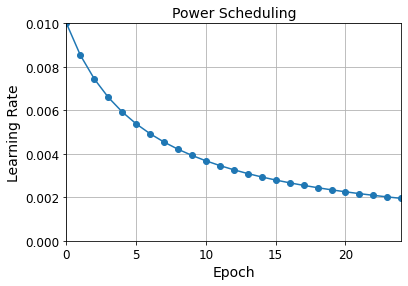

In [25]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Exponential Scheduling 

lr = lr0 * 0.1**(epoch / s)

In [26]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [27]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [29]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8868 - accuracy: 0.7533 - val_loss: 1.0318 - val_accuracy: 0.7572
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7487 - accuracy: 0.7910 - val_loss: 0.7331 - val_accuracy: 0.8116
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6645 - accuracy: 0.8145 - val_loss: 0.7652 - val_accuracy: 0.7806
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6245 - accuracy: 0.8222 - val_loss: 0.5193 - val_accuracy: 0.8520
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5598 - accuracy: 0.8396 - val_loss: 0.5488 - val_accuracy: 0.8482
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4865 - accuracy: 0.8547 - val_loss: 0.6547 - val_accuracy: 0.8534
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5206 - accuracy: 0.8581 - val_loss: 0.5039 - val_accuracy:

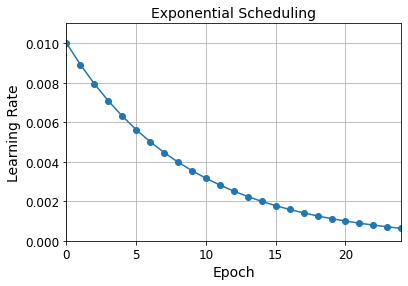

In [30]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [31]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [32]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7826 - accuracy: 0.7677 - val_loss: 0.8042 - val_accuracy: 0.7806
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6862 - accuracy: 0.7964 - val_loss: 0.5418 - val_accuracy: 0.8308
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6081 - accuracy: 0.8184 - val_loss: 0.7503 - val_accuracy: 0.7978
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5530 - accuracy: 0.8363 - val_loss: 0.4967 - val_accuracy: 0.8514
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5092 - accuracy: 0.8450 - val_loss: 0.4771 - val_accuracy: 0.8590
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4585 - accuracy: 0.8607 - val_loss: 0.4567 - val_accuracy: 0.8588
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4321 - accuracy: 0.8688 - val_loss: 0.4569 - val_accuracy:

In [33]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

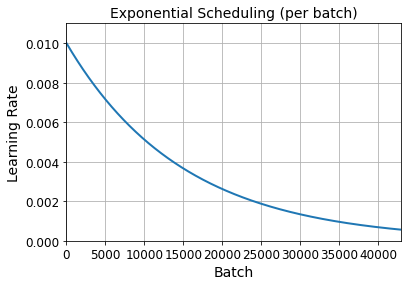

In [34]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

## Piecewise Constant Scheduling

Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs),
then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50
epochs), and so on. Although this solution can work very well, it requires fiddling
around to figure out the right sequence of learning rates and how long to
use each of them.

In [35]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [36]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [37]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9058 - accuracy: 0.7421 - val_loss: 0.9082 - val_accuracy: 0.6952
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8512 - accuracy: 0.7563 - val_loss: 0.7354 - val_accuracy: 0.8050
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8602 - accuracy: 0.7427 - val_loss: 1.1769 - val_accuracy: 0.5606
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2344 - accuracy: 0.5382 - val_loss: 1.1638 - val_accuracy: 0.5440
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2475 - accuracy: 0.5303 - val_loss: 1.2114 - val_accuracy: 0.5376
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0141 - accuracy: 0.5711 - val_loss: 1.0062 - val_accuracy: 0.5632
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9686 - accuracy: 0.5809 - val_loss: 1.1406 - val_accuracy:

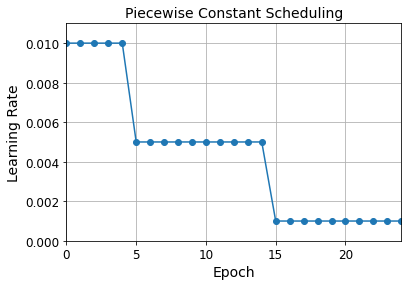

In [38]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Performance scheduling

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

In [40]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5900 - accuracy: 0.8068 - val_loss: 0.4719 - val_accuracy: 0.8506
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4897 - accuracy: 0.8415 - val_loss: 0.6139 - val_accuracy: 0.8268
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5159 - accuracy: 0.8403 - val_loss: 0.5231 - val_accuracy: 0.8482
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5217 - accuracy: 0.8467 - val_loss: 0.4573 - val_accuracy: 0.8538
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5321 - accuracy: 0.8478 - val_loss: 0.4612 - val_accuracy: 0.8562
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4952 - accuracy: 0.8553 - val_loss: 0.5051 - val_accuracy: 0.8456
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4987 - accuracy: 0.8570 - val_loss: 0.5012 - val_accuracy:

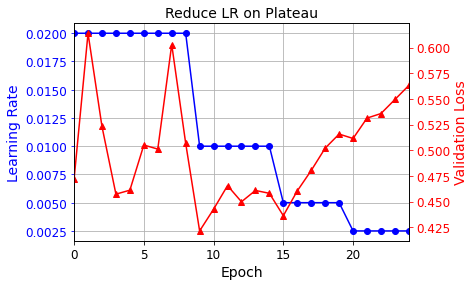

In [41]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## tf.keras schedulers

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4893 - accuracy: 0.8274 - val_loss: 0.4095 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3819 - accuracy: 0.8651 - val_loss: 0.3740 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3486 - accuracy: 0.8763 - val_loss: 0.3736 - val_accuracy: 0.8684
Epoch 4/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3264 - accuracy: 0.8837 - val_loss: 0.3495 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3103 - accuracy: 0.8896 - val_loss: 0.3433 - val_accuracy: 0.8800
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2958 - accuracy: 0.8952 - val_loss: 0.3417 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2853 - accuracy: 0.8987 - val_loss: 0.3357 - val_accuracy:

For piecewise constant scheduling, try this:

In [43]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

## 1 Cycle Scheduling

Contrary to the other approaches, 1cycle (introduced in a 2018 paper by Leslie
Smith) starts by increasing the initial learning rate η0, growing linearly up to η1
halfway through training. Then it decreases the learning rate linearly down to η0
again during the second half of training, finishing the last few epochs by dropping
the rate down by several orders of magnitude (still linearly). The maximum
learning rate η1 is chosen using the same approach we used to find the optimal
learning rate, and the initial learning rate η0 is chosen to be roughly 10 times
lower. When using a momentum, we start with a high momentum first (e.g.,
0.95), then drop it down to a lower momentum during the first half of training
(e.g., down to 0.85, linearly), and then bring it back up to the maximum value
(e.g., 0.95) during the second half of training, finishing the last few epochs with
that maximum value. Smith did many experiments showing that this approach
was often able to speed up training considerably and reach better performance.
For example, on the popular CIFAR10 image dataset, this approach reached
91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800
epochs through a standard approach (with the same neural network
architecture).

In [44]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 3ms/step - loss: 7230127879999193088.0000 - accuracy: 0.3852


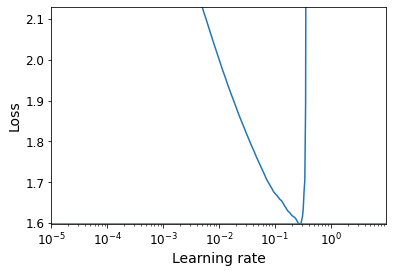

In [46]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [47]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [48]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4122 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8580
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3867 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3765 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.8775 - val_loss: 0.3745 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3636 - val_accuracy: 0.8712
Epoch 

## Summary
Exponential decay, performance scheduling, and 1cycle can considerably
speed up convergence, so give them a try!

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Just like you did in Chapter 4 for simple linear models, you can use ℓ2 regularization
to constrain a neural network’s connection weights, and/or ℓ1 regularization if you
want a sparse model (with many weights equal to 0)

In [49]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

Since you will typically want to apply the same regularizer to all layers in your network,
as well as using the same activation function and the same initialization strategy
in all hidden layers, you may find yourself repeating the same arguments. This
makes the code ugly and error-prone. To avoid this, you can try refactoring your code
to use loops. Another option is to use Python’s functools.partial() function,
which lets you create a thin wrapper for any callable, with some default argument
values:

In [50]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 1.6223 - accuracy: 0.8109 - val_loss: 0.7201 - val_accuracy: 0.8306
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7204 - accuracy: 0.8269 - val_loss: 0.6843 - val_accuracy: 0.8368


## Dropout

Dropout is one of the most popular regularization techniques for deep neural networks.
It was proposed in a paper23 by Geoffrey Hinton in 2012 and further detailed
in a 2014 paper24 by Nitish Srivastava et al., and it has proven to be highly successful:
even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding
dropout. This may not sound like a lot, but when a model already has 95% accuracy,
getting a 2% accuracy boost means dropping the error rate by almost 40% (going
from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the
input neurons, but always excluding the output neurons) has a probability p of being
temporarily “dropped out,” meaning it will be entirely ignored during this training
step, but it may be active during the next step (see Figure 11-9). The hyperparameter
p is called the dropout rate, and it is typically set between 10% and 50%: closer to 20–
30% in recurrent neural nets (see Chapter 15), and closer to 40–50% in convolutional
neural networks (see Chapter 14). After training, neurons don’t get dropped anymore.

![](images/dropout.png)

**NOTE**: In practice, you can usually apply dropout only to the neurons in
the top one to three layers (excluding the output layer).

There is one small but important technical detail. Suppose p = 50%, in which case
during testing a neuron would be connected to twice as many input neurons as it
would be (on average) during training. To compensate for this fact, we need to multiply
each neuron’s input connection weights by 0.5 after training. If we don’t, each
neuron will get a total input signal roughly twice as large as what the network was
trained on and will be unlikely to perform well. More generally, we need to multiply
each input connection weight by the keep probability (1 – p) after training. Alternatively,
we can divide each neuron’s output by the keep probability during training
(these alternatives are not perfectly equivalent, but they work equally well). Keras handles this automatically.

In [51]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5597 - accuracy: 0.8059 - val_loss: 0.3672 - val_accuracy: 0.8656
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4230 - accuracy: 0.8455 - val_loss: 0.3464 - val_accuracy: 0.8686


**WARNING**: Since dropout is only active during training, comparing the training
loss and the validation loss can be misleading. In particular, a
model may be overfitting the training set and yet have similar
training and validation losses. So make sure to evaluate the training
loss without dropout (e.g., after training).

If you observe that the model is **overfitting, you can increase the dropout rate.** Conversely,
you should try **decreasing the dropout rate if the model underfits** the training
set. It can also help to increase the dropout rate for large layers, and reduce it for
small ones. Moreover, many state-of-the-art architectures only use dropout after the
last hidden layer, so you may want to try this if full dropout is too strong.

Dropout does tend to significantly slow down convergence, but it usually results in a
much better model when tuned properly. So, it is generally well worth the extra time
and effort.

## Alpha Dropout

**NOTE**: If you want to regularize a self-normalizing network based on the
SELU activation function (as discussed earlier), you should use
alpha dropout: this is a variant of dropout that preserves the mean
and standard deviation of its inputs (it was introduced in the same
paper as SELU, as regular dropout would break self-normalization).

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6654 - accuracy: 0.7595 - val_loss: 0.5929 - val_accuracy: 0.8406
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5605 - accuracy: 0.7931 - val_loss: 0.5614 - val_accuracy: 0.8402
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5284 - accuracy: 0.8049 - val_loss: 0.4842 - val_accuracy: 0.8584- accu
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5072 - accuracy: 0.8115 - val_loss: 0.4614 - val_accuracy: 0.8588
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4917 - accuracy: 0.8183 - val_loss: 0.4690 - val_accuracy: 0.8562
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4866 - accuracy: 0.8185 - val_loss: 0.4728 - val_accuracy: 0.8604
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4718 - accuracy: 0.8247 - val_loss: 0.4687 - val_acc

In [54]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4391 - accuracy: 0.8663


[0.4390813112258911, 0.8662999868392944]

In [55]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3251 - accuracy: 0.8891: 1s - - ETA: 0s - loss: 0.3247 - accu - ETA: 0s - loss: 0.3265 - accuracy: 0.


[0.3251270353794098, 0.889090895652771]

In [56]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 3ms/step - loss: 0.4162 - accuracy: 0.8471


## MC Dropout

If this all sounds like a “one weird trick” advertisement, then take a look at the following
code. It is the full implementation of MC Dropout, boosting the dropout model
we trained earlier without retraining it:

SKIPPED

## Max-Norm Regularization

In [72]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [73]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4743 - accuracy: 0.8333 - val_loss: 0.3733 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3546 - accuracy: 0.8710 - val_loss: 0.3715 - val_accuracy: 0.8634
